In [1]:
# Clear variables
%reset

## Libraries

In [2]:
import pandas as pd
import pm4py
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz-11.0.0-win64/bin/'
from pm4py.objects.log.util import dataframe_utils
from pm4py.objects.conversion.log import converter as log_converter
from datetime import datetime
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
from main import print_log_info

## Loading Event Log

In [3]:
log_df = pd.read_csv('data\\sepsis cases.csv', sep=',')
log_df['@@case_index'] = log_df['@@case_index'].apply(str)
log_df.rename(columns={'@@case_index': 'case:concept:name', 'case:concept:name': 'Case Name'}, inplace=True)
log_df['time:timestamp']= pd.to_datetime(log_df['time:timestamp'])
# Convert column to numeric, turning 'nan' strings to NaN values

log_df['Leucocytes'] = pd.to_numeric(log_df['Leucocytes'], errors='coerce')
log_df['LacticAcid'] = pd.to_numeric(log_df['LacticAcid'], errors='coerce')

## Studying Event Log

In [4]:
# All activities in full Event Log

activities = pm4py.get_event_attribute_values(log_df, "concept:name")
pprint(activities)

{'Admission IC': 117,
 'Admission NC': 1182,
 'CRP': 3262,
 'ER Registration': 1050,
 'ER Sepsis Triage': 1049,
 'ER Triage': 1053,
 'IV Antibiotics': 823,
 'IV Liquid': 753,
 'LacticAcid': 1466,
 'Leucocytes': 3383,
 'Release A': 671,
 'Release B': 56,
 'Release C': 25,
 'Release D': 24,
 'Release E': 6,
 'Return ER': 294}


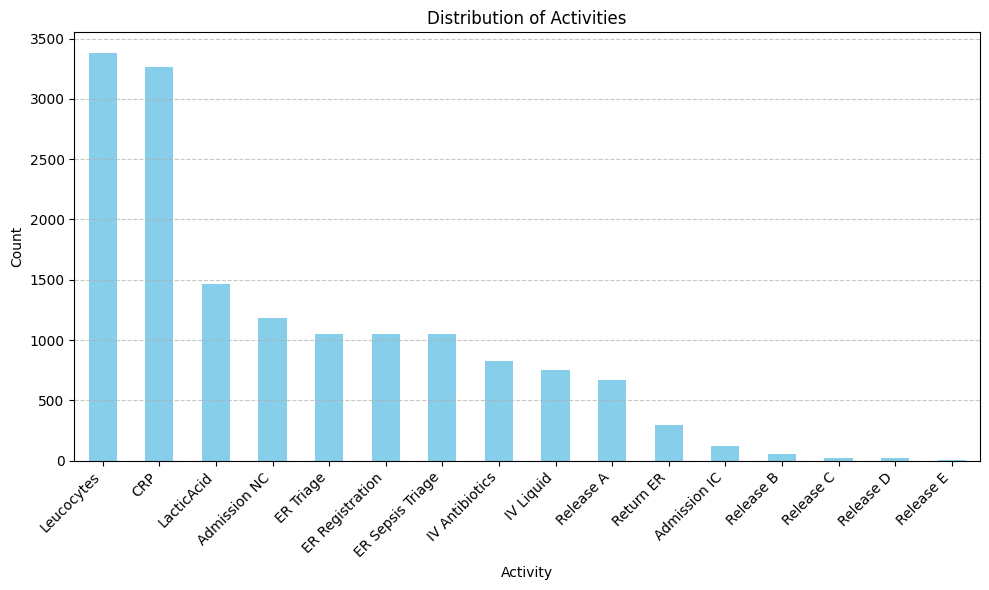

In [5]:
# Count frequency of activities

grouped_counts = log_df.groupby('concept:name').size().sort_values(ascending=False)

# Plotting the bar chart
plt.figure(figsize=(10, 6))
grouped_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Activities')
plt.xlabel('Activity')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

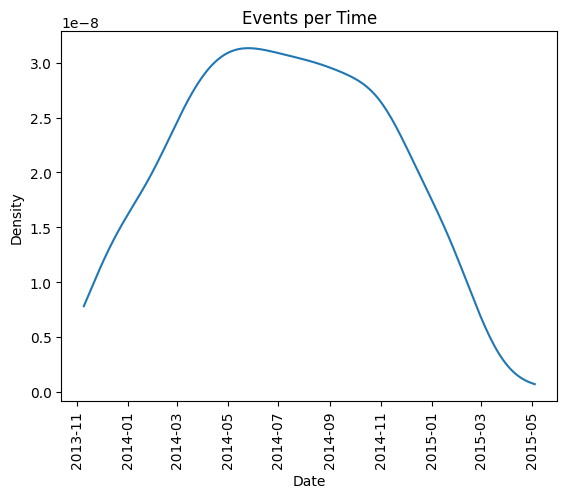

In [6]:
# occurrence of events in time

pm4py.view_events_per_time_graph(log_df, format='png', activity_key='concept:name',
                                 case_id_key='case:concept:name', timestamp_key='time:timestamp')

In [13]:
pm4py.save_vis_events_per_time_graph(log_df, 'charts\\ev_time.png', activity_key='concept:name', case_id_key='case:concept:name', timestamp_key='time:timestamp')

''

Number of events: 15214 (100.00%)
Number of cases: 1050 (100.00%)


Start activities: {'ER Registration': 995, 'Leucocytes': 18, 'IV Liquid': 14, 'CRP': 10, 'ER Sepsis Triage': 7, 'ER Triage': 6}
End activities: {'Release A': 393, 'Return ER': 291, 'IV Antibiotics': 87, 'Release B': 55, 'ER Sepsis Triage': 49, 'Leucocytes': 44, 'CRP': 41, 'LacticAcid': 24, 'Release C': 19, 'Admission NC': 14, 'Release D': 14, 'IV Liquid': 12, 'Release E': 5, 'ER Triage': 2}


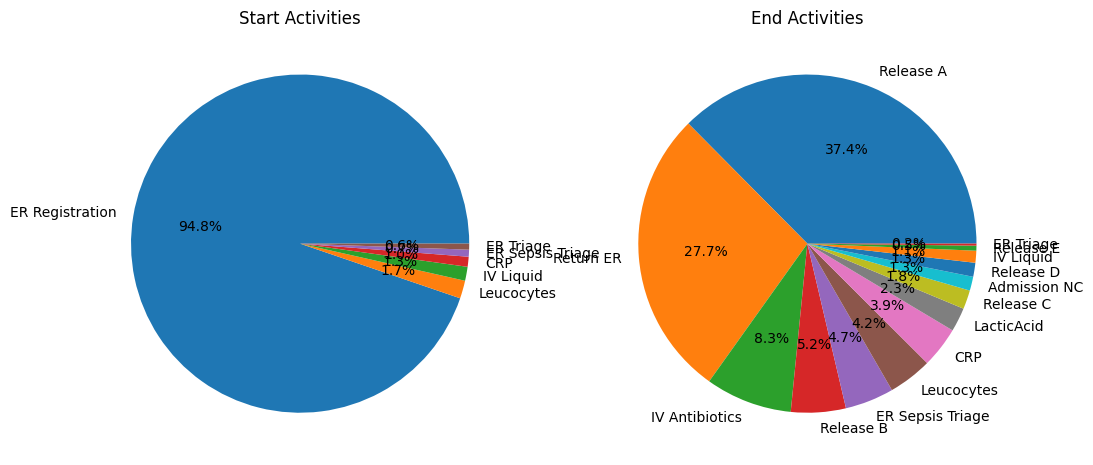

In [15]:
_, num_cases = print_log_info(log_df)
start_activities = pm4py.get_start_activities(log_df)
end_activities = pm4py.get_end_activities(log_df)
start_activities =  dict(sorted(start_activities.items(), key=lambda item: item[1], reverse=True))
end_activities =  dict(sorted(end_activities.items(), key=lambda item: item[1], reverse=True))
print("Start activities: {}\nEnd activities: {}".format(start_activities, end_activities))

# Create subplots with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))

# Plot pie chart for start activities
ax1.pie(start_activities.values(), labels=start_activities.keys(), autopct='%1.1f%%')
ax1.set_title('Start Activities')

# Plot pie chart for end activities
ax2.pie(end_activities.values(), labels=end_activities.keys(), autopct='%1.1f%%')
ax2.set_title('End Activities')

plt.show()
# fig.savefig('charts\\start_end_activities.png', dpi=300, bbox_inches='tight')


In [8]:
filtered_log_dfq = pm4py.filter_start_activities(log_df, ['ER Registration'])
filtered_log_dfq = pm4py.filter_end_activities(filtered_log_dfq, ['IV Antibiotics'])

print("Given {} total cases in the log we have {} cases whose final activity is 'IV Antibiotics'".format(num_cases, len(filtered_log_dfq['case:concept:name'].unique())))

Given 1050 total cases in the log we have 82 cases whose final activity is 'IV Antibiotics'


In [9]:
# Filter the DataFrame for rows where @@classifier is 'ER Registration'
filtered_log_dfw = log_df[log_df['@@classifier'] == 'ER Registration']

# Select Diagnostic columns
diagnostic_columns = filtered_log_dfw.filter(regex='^Diagnostic.*')

# Initialize a dictionary to hold the counts
counts = {}

for col in diagnostic_columns.columns:
    value_counts = diagnostic_columns[col].value_counts(dropna=False)
    counts[col] = {
        'True': value_counts.get(True, 0),
        'False': value_counts.get(False, 0),
    }

# Convert the dictionary to a DataFrame
result_df = pd.DataFrame(counts).T.fillna(0)
result_df = result_df.sort_values(by='True', ascending=False)
result_df

,True,False
DiagnosticIC,848,202
DiagnosticBlood,823,227
DiagnosticLacticAcid,804,246
DiagnosticXthorax,785,265
DiagnosticECG,765,285
DiagnosticUrinarySediment,519,531
DiagnosticUrinaryCulture,476,574
DiagnosticArtAstrup,297,753
DiagnosticSputum,29,1021
DiagnosticOther,10,1040


## Filtering data
- Incomplete cases according to start and end activity
- Incomplete cases according to activity 'ER Registration' and basic medical procedures
- Incomplete cases according to Leucocytes and CRP measurements, that are NaN (Not a Number) in corresponding activities
- (?) checking if any case lasts less than 1 hour

In [10]:
# Incomplete cases according to start and end activity

filtered_log_df = pm4py.filter_end_activities(log_df, ['Release A', 'Release B', 'Release E', 'Release C', 'Release D', 'Return ER', 'IV Antibiotics'])
# filtered_log_df = pm4py.filter_end_activities(log_df, ['Release A', 'Release B', 'Release E', 'Release C', 'Release D', 'Return ER'])
filtered_log_df = pm4py.filter_start_activities(filtered_log_df, ['ER Registration', 'ER Sepsis Triage', 'ER Triage'])
# filtered_log_df = pm4py.filter_start_activities(filtered_log_df, ['ER Registration'])

print("Given {} total cases in the log we have {} cases that comply with constraints for complete cases according to start and end activity".format(num_cases, len(filtered_log_df['case:concept:name'].unique())))

Given 1050 total cases in the log we have 827 cases that comply with constraints for complete cases according to start and end activity


In [11]:
# Incomplete cases according to activity ‘ER Registration’ and basic medical procedures

filtered = filtered_log_df[filtered_log_df['@@classifier'] == 'ER Registration']
# Count the number of cases where none of blood test was done or the basic diagnostic IC
logical_sum_filter = (filtered[['DiagnosticBlood', 'DiagnosticIC', 'DiagnosticLacticAcid', 'DiagnosticArtAstrup']].any(axis=1) == False)
uncompleted_ER_Registration = logical_sum_filter.sum()

print("Given {} total cases in the log we have {} cases that passed incomplete ER Registration".format(num_cases, uncompleted_ER_Registration))

# Get the unique values from the 'case:concept:name' column
unique_cases = filtered[logical_sum_filter]['case:concept:name'].unique()
filtered_log_df = filtered_log_df[~filtered_log_df['case:concept:name'].isin(unique_cases)]

print("Given {} total cases in the log we have {} cases comply the constraints according to start/end activity and completeness of medical procedures in ER Registration activity".format(num_cases, len(filtered_log_df['case:concept:name'].unique())))



Given 1050 total cases in the log we have 85 cases that passed incomplete ER Registration
Given 1050 total cases in the log we have 742 cases comply the constraints according to start/end activity and completeness of medical procedures in ER Registration activity


In [16]:
# Incomplete cases according to Leucocytes and CRP measurements, that are NaN in corresponding activities
leucocytes_nan_cases = filtered_log_df[ filtered_log_df['concept:name'] == 'Leucocytes' ][ ['Leucocytes', 'case:concept:name'] ]
nan_leucocytes_cases = leucocytes_nan_cases[leucocytes_nan_cases['Leucocytes'].isna()]
unique_nan_leucocytes_cases = nan_leucocytes_cases['case:concept:name'].unique()

print("Given {} total cases in the log we have {} cases passed incomplete Leucocytes measurement, giving unknown value".format(num_cases, len(unique_nan_leucocytes_cases)))

crp_nan_cases = filtered_log_df[filtered_log_df['concept:name'] == 'CRP'][['CRP', 'case:concept:name']]
nan_crp_cases = crp_nan_cases[crp_nan_cases['CRP'].isna()]
unique_nan_crp_cases = nan_crp_cases['case:concept:name'].unique()

print("Given {} total cases in the log we have {} cases passed incomplete Leucocytes measurement, giving unknown value".format(num_cases, len(unique_nan_crp_cases)))

filtered_log_df = filtered_log_df[~filtered_log_df['case:concept:name'].isin(unique_nan_leucocytes_cases)]
filtered_log_df = filtered_log_df[~filtered_log_df['case:concept:name'].isin(unique_nan_crp_cases)]

print("Common cases for CRP and Leucocytes:",  len(set(unique_nan_leucocytes_cases) & set(unique_nan_crp_cases)))

print("Given {} total cases in the log we have {} cases comply the constraints according to start/end activity, completeness of medical procedures in ER Registration activity and completeness of Leucocytes and CRP measurements".format(num_cases, len(filtered_log_df['case:concept:name'].unique())))


Given 1050 total cases in the log we have 23 cases passed incomplete Leucocytes measurement, giving unknown value
Given 1050 total cases in the log we have 56 cases passed incomplete Leucocytes measurement, giving unknown value
Common cases for CRP and Leucocytes: 10
Given 1050 total cases in the log we have 673 cases comply the constraints according to start/end activity, completeness of medical procedures in ER Registration activity and completeness of Leucocytes and CRP measurements


### Case duration
 - investigate the average duration of cases
 - investigate the extreme cases according to duration and number of events
 - filtering too short cases (cases shorter than 0.5 hour)
 - investigate the corelation between number of events and duration of single case

There is at least one case that lasts lower than 1 hour


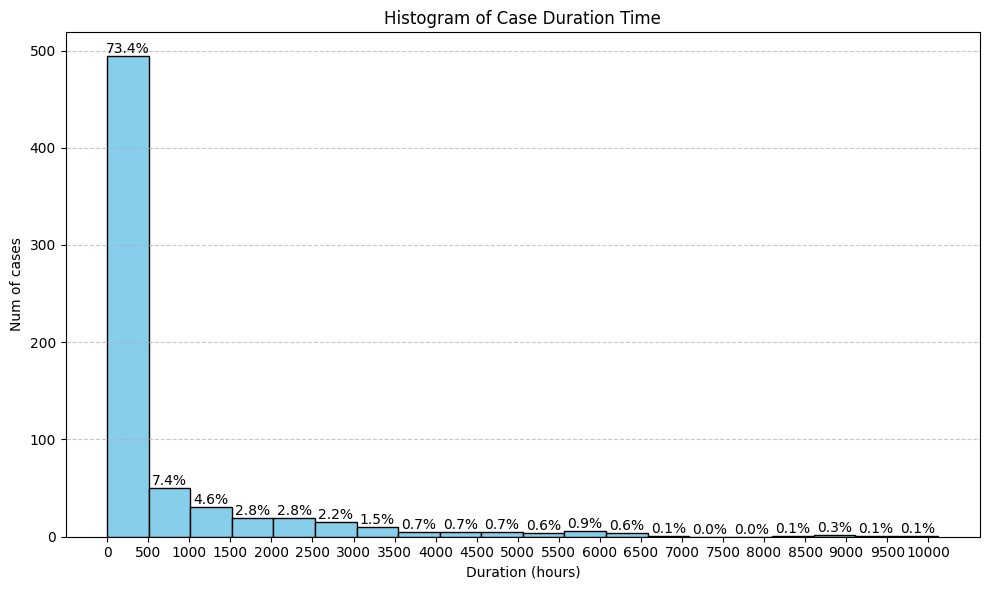

In [19]:
# investigate the average duration of cases

case_durations = pm4py.get_all_case_durations(filtered_log_df, activity_key='concept:name', case_id_key='case:concept:name', timestamp_key='time:timestamp')
case_durations_hours = [duration / (3600) for duration in case_durations]
case_durations_hours.sort(reverse=False)

if any(duration < 1 for duration in case_durations_hours):
    print("There is at least one case that lasts lower than 1 hour")
else:
    print("All cases are longer than 1 hour")

# Plotting the histogram
plt.figure(figsize=(10, 6))
# plt.hist(case_durations_hours, bins=20, color='skyblue', edgecolor='black')
n, bins, patches = plt.hist(case_durations_hours, bins=20, color='skyblue', edgecolor='black')

plt.title('Histogram of Case Duration Time')
plt.xlabel('Duration (hours)')
plt.ylabel('Num of cases')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.xticks(np.arange(0, max(case_durations_hours) + 1, 500))

# Add percentage labels on the bars
for i in range(len(patches)):
    x = patches[i].get_x() + patches[i].get_width() / 2
    y = patches[i].get_height()
    percentage = '{:.1f}%'.format(100 * y / len(case_durations_hours))
    plt.text(x, y, percentage, ha='center', va='bottom')
plt.show()

# plt.savefig('charts\\histogram_case_duration_time.png', dpi=300, bbox_inches='tight')

In [14]:
## Alternative way using dataframe to show the case durations
case_durations_df = filtered_log_df.groupby('case:concept:name').agg(\
Events=('case:concept:name', 'count'),\
# Multiple aggregations of the same column using pandas ...
FirstOccurence=('time:timestamp', lambda x: x.min()),
LastOccurence=('time:timestamp', lambda x: x.max()),
Duration=('time:timestamp', lambda x: x.max() - x.min()),
DurationHours=('time:timestamp', lambda x: ( x.max() - x.min() ).total_seconds() / 3600 ),
)

case_durations_df = case_durations_df.sort_values(by='DurationHours', ascending=False)
case_durations_df
# type(case_durations_df['Duration'].iloc[0])

,Events,FirstOccurence,LastOccurence,Duration,DurationHours
case:concept:name,,,,,
136,20,2014-02-05 15:09:05+02:00,2015-04-03 10:55:52+02:00,421 days 19:46:47,10123.779722
394,15,2014-05-08 11:58:15+02:00,2015-05-30 11:14:55+02:00,386 days 23:16:40,9287.277778
87,12,2014-01-04 21:49:48+02:00,2015-01-04 20:28:24+02:00,364 days 22:38:36,8758.643333
59,15,2013-12-19 20:47:57+02:00,2014-12-19 03:38:36+02:00,364 days 06:50:39,8742.844167
168,15,2014-02-18 23:28:35+02:00,2015-01-27 14:12:50+02:00,342 days 14:44:15,8222.737500
...,...,...,...,...,...
258,7,2014-03-20 14:42:34+02:00,2014-03-20 15:07:16+02:00,0 days 00:24:42,0.411667
63,8,2013-12-21 14:41:21+02:00,2013-12-21 15:04:03+02:00,0 days 00:22:42,0.378333
998,8,2015-01-15 21:14:58+02:00,2015-01-15 21:35:59+02:00,0 days 00:21:01,0.350278


Events                                  185
FirstOccurence    2014-06-17 01:17:11+02:00
LastOccurence     2014-10-09 10:00:00+02:00
Duration                  114 days 08:42:49
DurationHours                   2744.713611
Name: 507, dtype: object


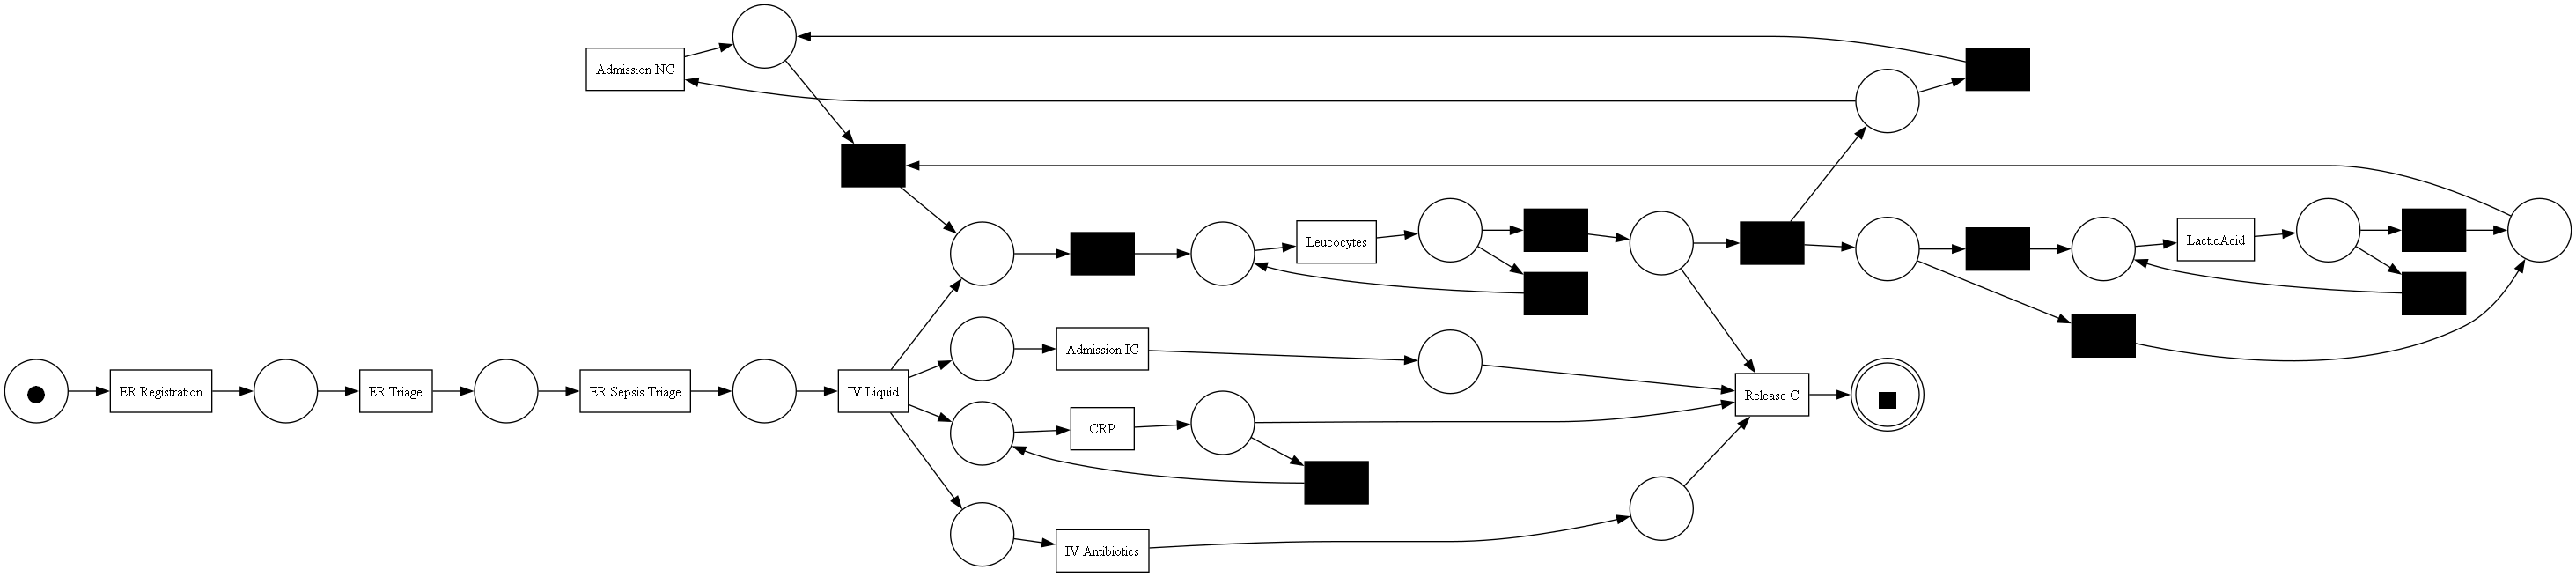

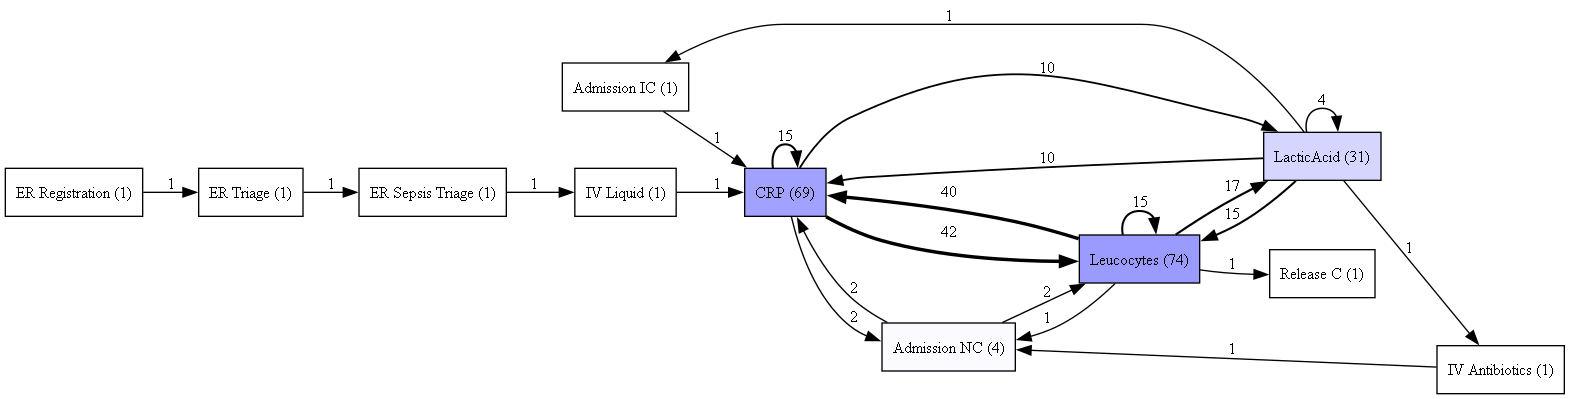

''

In [15]:
# investigate the extreme cases according to duration and number of events

# Specific conditions to illustrate
# case_id = '406'  # the shortest case by duration
# chart = 'shortestDurationCase'
# case_id = '136'  # the longest case by duration
# chart = 'longestDurationCase'
# case_id = '469'  # the least case by number of events
# chart = 'leastEventCase'
case_id = '507'  # the most case by number of events
chart = 'mostEventCase'

# Saving information about specific case
row = case_durations_df.loc[case_id]
row_info = f"Information for case_id '{case_id}':\n\n{row.to_string()}"
with open(f'charts\\{chart}Log.txt', 'w') as f:
        f.write(row_info)
pprint(row)

single_case_df = filtered_log_df[filtered_log_df['case:concept:name'] == case_id].copy()
single_case_df = dataframe_utils.convert_timestamp_columns_in_df(single_case_df)

net, im, fm = pm4py.discover_petri_net_inductive(single_case_df)
pm4py.view_petri_net(net, im, fm, format='png')
pm4py.save_vis_petri_net(net, im, fm, f"charts\\{chart}Petri.png")

# ======================================== DFG ========================================
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
## Import the dfg visualization object
from pm4py.visualization.dfg import visualizer as dfg_visualization

## Convert to log format
filtered_log = log_converter.apply(single_case_df)
#Create graph from log
dfg = dfg_discovery.apply(single_case_df)
# Visualise
gviz = dfg_visualization.apply(dfg, log=single_case_df, variant=dfg_visualization.Variants.FREQUENCY)
dfg_visualization.view(gviz)
dfg_visualization.save(gviz, f"charts\\{chart}DFG.png")

In [16]:
# filtering too short cases (cases shorter than 0.5 hour)
unique_short_duration_cases = case_durations_df[case_durations_df['DurationHours'] < 0.5].index
filtered_log_df = filtered_log_df[~filtered_log_df['case:concept:name'].isin(unique_short_duration_cases)]

print("Given {} total cases in the log we have {} cases that last less than 0.5 hour".format(num_cases, len(unique_short_duration_cases)))
print("Given {} total cases in the log we have {} cases comply the constraints according to start/end activity, completeness of medical procedures in ER Registration activity, completeness of Leucocytes and CRP measurements and minimal duration time".format(num_cases, len(filtered_log_df['case:concept:name'].unique())))


Given 1050 total cases in the log we have 6 cases that last less than 0.5 hour
Given 1050 total cases in the log we have 667 cases comply the constraints according to start/end activity, completeness of medical procedures in ER Registration activity, completeness of Leucocytes and CRP measurements and minimal duration time


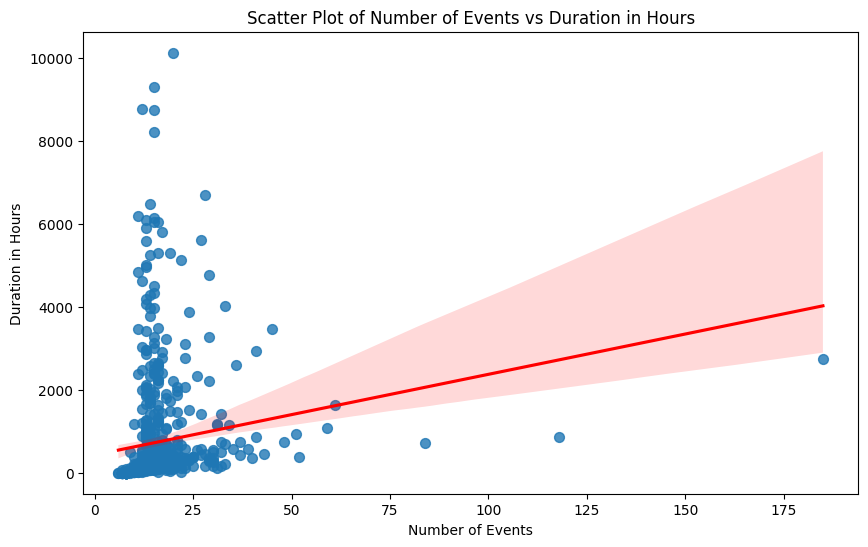

In [17]:
# investigate the corelation between number of events and duration of single case

import matplotlib.pyplot as plt
import seaborn as sns

# Create a scatter plot with a regression line
plt.figure(figsize=(10, 6))
sns.regplot(x='Events', y='DurationHours', data=case_durations_df[ ['Events', 'DurationHours'] ], scatter_kws={'s':50}, line_kws={'color':'red'})
plt.xlabel('Number of Events')
plt.ylabel('Duration in Hours')
plt.title('Scatter Plot of Number of Events vs Duration in Hours')
plt.show()

In [18]:
from scipy.stats import pearsonr

# Calculate the Pearson correlation coefficient and p-value
correlation, p_value = pearsonr(case_durations_df['Events'], case_durations_df['DurationHours'])

print(f"Pearson correlation coefficient: {correlation}")
print(f"P-value: {p_value}")


Pearson correlation coefficient: 0.14619252604413993
P-value: 0.00014124475953044145


### Activities frequency for unique cases
 - filtering the cases that all share the same activity (reject single case that doesn't have 'ER Sepsis Triage' activity)

In [19]:
# Group by 'concept:name' and count unique 'case:concept:name'
activity_counts = filtered_log_df.groupby('concept:name')['case:concept:name'].nunique().reset_index()

# Total unique cases
total_unique_cases = filtered_log_df['case:concept:name'].nunique()

# Calculate cases without each activity
activity_counts['Not Containing'] = total_unique_cases - activity_counts['case:concept:name']

# Rename columns for clarity
activity_counts.columns = ['Activity', 'Containing', 'Not Containing']
activity_counts = activity_counts.sort_values(by='Containing', ascending=False)
activity_counts = activity_counts.reset_index(drop=True)

# Print the DataFrame
print(activity_counts)

            Activity  Containing  Not Containing
0                CRP         667               0
1    ER Registration         667               0
2          ER Triage         667               0
3         Leucocytes         667               0
4   ER Sepsis Triage         666               1
5     IV Antibiotics         650              17
6         LacticAcid         638              29
7       Admission NC         593              74
8          IV Liquid         591              76
9          Release A         524             143
10         Return ER         227             440
11      Admission IC          79             588
12         Release B          37             630
13         Release C          18             649
14         Release D          14             653
15         Release E           3             664


In [20]:
# Identify single case that do not contain 'ER Sepsis Triage'

# Filter out cases that contain 'ER Sepsis Triage'
cases_with_sepsis_triage = filtered_log_df[filtered_log_df['concept:name'] == 'ER Sepsis Triage']['case:concept:name'].unique()

# Identify cases that do not contain 'ER Sepsis Triage'
case_without_sepsis_triage = filtered_log_df[~filtered_log_df['case:concept:name'].isin(cases_with_sepsis_triage)]['case:concept:name'].unique()
filtered_log_df = filtered_log_df[~filtered_log_df['case:concept:name'].isin(case_without_sepsis_triage)]
print("Given {} total cases in the log we have {} cases comply all the constraints".format(num_cases, len(filtered_log_df['case:concept:name'].unique())))


Given 1050 total cases in the log we have 666 cases comply all the constraints


In [21]:
# Saving filtered dataframe to .csv

current_timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# Construct filename with timestamp
filename = f"data\\sepsis_filtered_data_{current_timestamp}.csv"
filtered_log_df.to_csv(filename, index=False)